Imports

In [1]:
import folium
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
%matplotlib inline

Display Settings

In [15]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

Load Data

In [3]:
position_df = pd.read_csv("position_report_data.csv")
airport_df = pd.read_csv("airport_data.csv")
runway_df = pd.read_csv("runway_data.csv")

In [4]:
print("Position Report Data (position_report_data.csv):")
print(position_df.info())
print(position_df.head(), "\n")

Position Report Data (position_report_data.csv):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 658643 entries, 0 to 658642
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   dt          658643 non-null  object 
 1   mode_s      658643 non-null  object 
 2   identifier  658643 non-null  object 
 3   latitude    658643 non-null  float64
 4   longitude   658643 non-null  float64
 5   altitude    658643 non-null  float64
 6   icao_code   645426 non-null  object 
dtypes: float64(3), object(4)
memory usage: 35.2+ MB
None
                        dt    mode_s identifier   latitude  longitude  \
0  2024-07-01 00:00:00.047  7a74f268   a03a1152  40.777731 -73.871319   
1  2024-07-01 00:00:00.117  86196a3c   3df8084e  40.829616 -73.834240   
2  2024-07-01 00:00:00.516  813b10b4   4f912fcd  40.714538 -73.972256   
3  2024-07-01 00:00:00.594  d721ddf0   3499273b  40.740137 -73.982728   
4  2024-07-01 00:00:00.602  86196a3c   3

In [5]:
print("Airport Data (airport_data.csv):")
print(airport_df.info())
print(airport_df.head(), "\n")

Airport Data (airport_data.csv):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   icao_code          1 non-null      object 
 1   type               1 non-null      object 
 2   name               1 non-null      object 
 3   latitude           1 non-null      float64
 4   longitude          1 non-null      float64
 5   elevation_ft       1 non-null      float64
 6   iso_country        1 non-null      object 
 7   iso_region         1 non-null      object 
 8   municipality       1 non-null      object 
 9   scheduled_service  1 non-null      object 
 10  gps_code           1 non-null      object 
 11  iata_code          1 non-null      object 
dtypes: float64(3), object(9)
memory usage: 224.0+ bytes
None
  icao_code           type                name   latitude  longitude  \
0      KLGA  large_airport  La Guardia Airport  40.777199 -7

In [6]:
print("Runway Data (runway_data.csv):")
print(runway_df.info())
print(runway_df.head(), "\n")

Runway Data (runway_data.csv):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 18 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   icao_code                  2 non-null      object 
 1   length_ft                  2 non-null      float64
 2   width_ft                   2 non-null      float64
 3   surface                    2 non-null      object 
 4   lighted                    2 non-null      int64  
 5   closed                     2 non-null      int64  
 6   le_ident                   2 non-null      int64  
 7   le_latitude_deg            2 non-null      float64
 8   le_longitude_deg           2 non-null      float64
 9   le_elevation_ft            2 non-null      float64
 10  le_heading_degT            2 non-null      float64
 11  le_displaced_threshold_ft  0 non-null      float64
 12  he_ident                   2 non-null      int64  
 13  he_latitude_deg        

Explore the position report data

In [23]:
# Convert the 'dt' column to a proper datetime for easier time-series plotting
position_df['dt'] = pd.to_datetime(position_df['dt'])

# Sort by dt just in case
position_df.sort_values(by='dt', inplace=True)

# Create a new column that combines 'mode_s' and 'identifier' to uniquely identify flights
position_df['unique_flight_id'] = position_df['mode_s'] + '_' + position_df['identifier']

# Identify unique flights in the dataset
unique_flights = position_df['unique_flight_id'].unique()
print(f"Number of unique flights found: {len(unique_flights)}")

# Display a few example unique flight IDs
print("Example unique flight IDs:")
for flight_id in unique_flights[:5]:  # Show the first 5 unique flight IDs
    print(flight_id)

# Let's review one flight:
sample_flight_id = unique_flights[0]  # Choose the first unique flight ID as a sample

# Filter the dataframe for the sample flight
sample_flight_df = position_df[position_df['unique_flight_id'] == sample_flight_id]

print(f"\nReviewing flight: {sample_flight_id}")
print(f"Number of data points: {len(sample_flight_df)}")
print(f"Time range: from {sample_flight_df['dt'].min()} to {sample_flight_df['dt'].max()}")



Number of unique flights found: 1504
Example unique flight IDs:
7a74f268_a03a1152
86196a3c_3df8084e
813b10b4_4f912fcd
d721ddf0_3499273b
f64f9590_87b278d3

Reviewing flight: 7a74f268_a03a1152
Number of data points: 289
Time range: from 2024-07-01 00:00:00.047000 to 2024-07-01 00:04:47.523000


In [26]:
# Filter the data for that flight
flight_df = position_df[position_df['unique_flight_id'] == sample_flight_id].copy()
flight_df.head(20)
# flight_df

,dt,mode_s,identifier,latitude,longitude,altitude,icao_code,unique_flight_id
0,2024-07-01 00:00:00.047,7a74f268,a03a1152,40.777731,-73.871319,0.000000,E75L,7a74f268_a03a1152
7,2024-07-01 00:00:01.203,7a74f268,a03a1152,40.777795,-73.871448,0.000000,E75L,7a74f268_a03a1152
13,2024-07-01 00:00:02.242,7a74f268,a03a1152,40.777838,-73.871555,0.000000,E75L,7a74f268_a03a1152
20,2024-07-01 00:00:03.148,7a74f268,a03a1152,40.777881,-73.871641,0.000000,E75L,7a74f268_a03a1152
26,2024-07-01 00:00:04.102,7a74f268,a03a1152,40.777924,-73.871748,0.000000,E75L,7a74f268_a03a1152
33,2024-07-01 00:00:05.109,7a74f268,a03a1152,40.777988,-73.871856,0.000000,E75L,7a74f268_a03a1152
38,2024-07-01 00:00:06.109,7a74f268,a03a1152,40.778031,-73.871963,0.000000,E75L,7a74f268_a03a1152
44,2024-07-01 00:00:07.195,7a74f268,a03a1152,40.778074,-73.872049,0.000000,E75L,7a74f268_a03a1152
48,2024-07-01 00:00:08.133,7a74f268,a03a1152,40.778139,-73.872156,0.000000,E75L,7a74f268_a03a1152
54,2024-07-01 00:00:09.156,7a74f268,a03a1152,40.778182,-73.872242,0.000000,E75L,7a74f268_a03a1152


Matplotlib

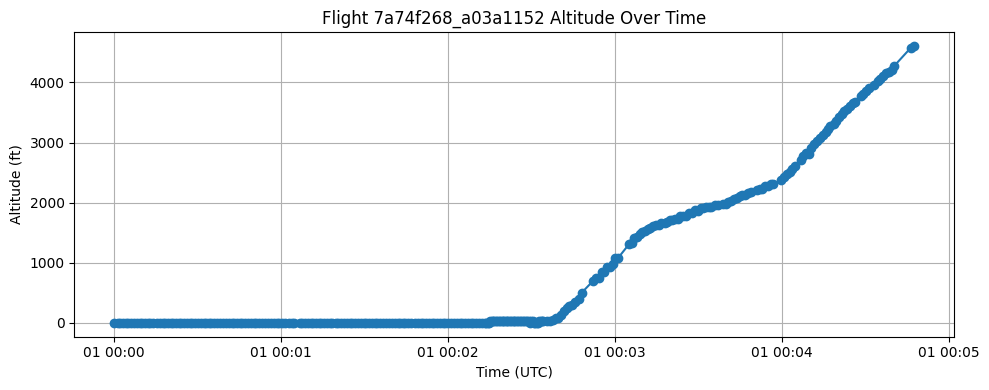

In [27]:
plt.figure(figsize=(10, 4))
plt.plot(flight_df['dt'], flight_df['altitude'], marker='o', linestyle='-')
plt.title(f"Flight {sample_flight_id} Altitude Over Time")
plt.xlabel("Time (UTC)")
plt.ylabel("Altitude (ft)")
plt.grid(True)
plt.tight_layout()
plt.show()

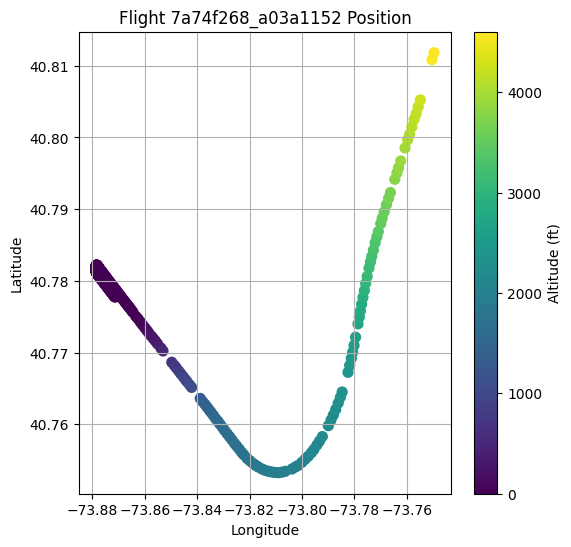

In [28]:
plt.figure(figsize=(6, 6))
plt.scatter(flight_df['longitude'], flight_df['latitude'],
            c=flight_df['altitude'], cmap='viridis', s=50)
plt.colorbar(label='Altitude (ft)')
plt.title(f"Flight {sample_flight_id} Position")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

Folium

In [29]:
# For a more visually pleasing geospatial visualization, we can create a Folium map:
mid_lat = flight_df['latitude'].mean()
mid_lon = flight_df['longitude'].mean()

m = folium.Map(location=[mid_lat, mid_lon], zoom_start=12)

# Add flight track as a line
coords = list(zip(flight_df['latitude'], flight_df['longitude']))
folium.PolyLine(coords, color='blue', weight=3, opacity=0.7).add_to(m)

# Add markers for start & end
start_point = coords[0]
end_point = coords[-1]
folium.Marker(start_point, popup="Start").add_to(m)
folium.Marker(end_point, popup="End").add_to(m)

In [30]:
m

In [31]:
# Get min, max, and average altitude for this flight
min_alt = flight_df['altitude'].min()
max_alt = flight_df['altitude'].max()
mean_alt = flight_df['altitude'].mean()

print(f"Basic Altitude Stats for Flight {sample_flight_id}:")
print(f"  Minimum Altitude: {min_alt:.2f} ft")
print(f"  Maximum Altitude: {max_alt:.2f} ft")
print(f"  Average Altitude: {mean_alt:.2f} ft\n")

Basic Altitude Stats for Flight 7a74f268_a03a1152:
  Minimum Altitude: 0.00 ft
  Maximum Altitude: 4604.39 ft
  Average Altitude: 855.97 ft



In [32]:
nearby_icao_codes = flight_df['icao_code'].unique()
print(f"Flight {sample_flight_id} was associated with these ICAO codes: {nearby_icao_codes}\n")

Flight 7a74f268_a03a1152 was associated with these ICAO codes: ['E75L']



In [33]:
merged_example = pd.merge(
    flight_df,
    airport_df,
    on="icao_code",
    how="left",  # so we don't lose flight data that doesn't match
    suffixes=("_pos", "_airport")
)
print("Merged flight data with airport info (sample rows):")
print(merged_example[['dt','identifier','latitude_pos','longitude_pos','name']].head())


Merged flight data with airport info (sample rows):
                       dt identifier  latitude_pos  longitude_pos name
0 2024-07-01 00:00:00.047   a03a1152     40.777731     -73.871319  NaN
1 2024-07-01 00:00:01.203   a03a1152     40.777795     -73.871448  NaN
2 2024-07-01 00:00:02.242   a03a1152     40.777838     -73.871555  NaN
3 2024-07-01 00:00:03.148   a03a1152     40.777881     -73.871641  NaN
4 2024-07-01 00:00:04.102   a03a1152     40.777924     -73.871748  NaN
